Данные можно взять отсюда: https://cloud.mail.ru/public/H8ty/ML8uHaTtA
Описание формата: https://www.kaggle.com/competitions/relevance-prediction-vk-edu-fall-2022/data

In [2]:
from collections import defaultdict

import pickle

import pandas as pd
import numpy as np

from tqdm import tqdm


In [2]:
# на минуточку, 340796067 строк
DATA_PATH = "G:/ML-storage/relevance-prediction-vk-fall-2022/click_log"
LINES = 340796067
# DOC_IDS = 117093271
# QUERY_IDS = 30717253
# 117093271 различных документов
# 14330717152003771520039 максимальный айди документа
# 30717253 различных запросов
# 1702028171 максимальный айди запроса
# 43977857 сессий в которых есть документы

Достаточно собрать метрики только для тех документов, которые есть в sample_submission и переранжировать их используя кликовые фичи

значит нам нужны только те сессии, в которых встречаются данные документы

Метрики будем собирать и считать сразу же, это ClickRank кликнутого документа и число кликов, чтобы затем посчитать средний клик ранк

In [3]:
from dataclasses import dataclass

@dataclass
class Query:
    session_id: int = -1
    time_passed: int = -1
    type_of_action: str = ""
    query_id: int = -1
    region_id: int = -1
    list_of_urls: tuple = ()

    def __post_init__(self):
        self.session_id = int(self.session_id)
        self.time_passed = int(self.time_passed)
        self.type_of_action = str(self.type_of_action)
        self.query_id = int(self.query_id)
        self.region_id = int(self.region_id)
        self.list_of_urls = tuple([int(x) for x in self.list_of_urls])

@dataclass
class Click:
    session_id: int = -1
    time_passed: int = -1
    type_of_action: str = ""
    url_id: int = -1

    def __post_init__(self):
        self.session_id = int(self.session_id)
        self.time_passed = int(self.time_passed)
        self.type_of_action = str(self.type_of_action)
        self.url_id = int(self.url_id)

@dataclass
class Metrics:
    clicked: int = 0
    click_rank_sum: float = 0


In [4]:
docs = defaultdict(Metrics)

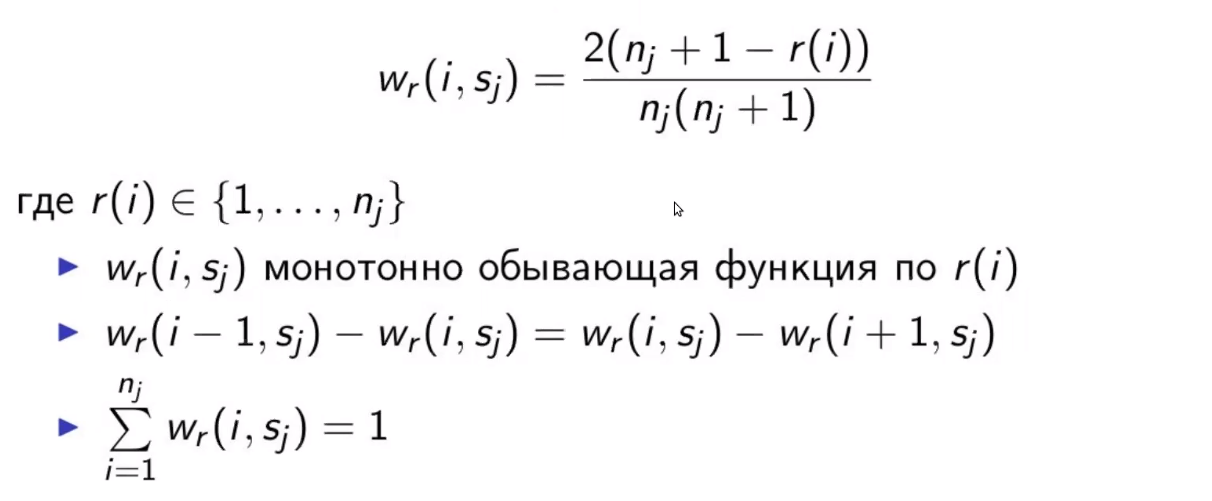

In [5]:
def w_r(r_i, n_j):
    return 2.0 * (n_j + 1  - r_i) / n_j / (n_j + 1)

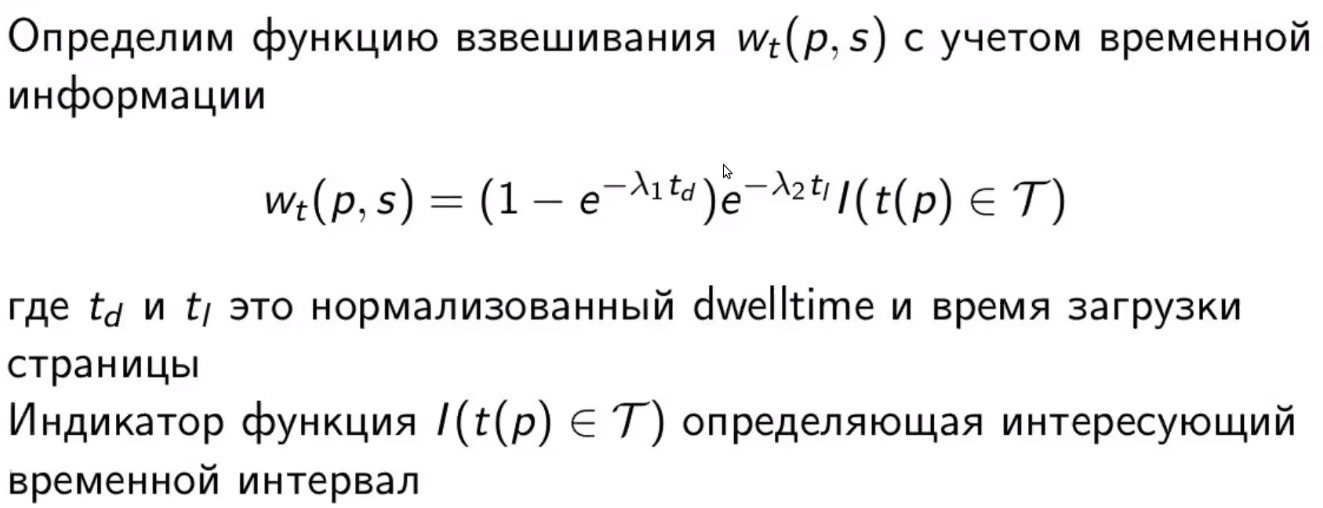

In [ ]:
def w_t(t_d):
    lambda_1 = 0.1
    return (1.0 - np.exp(-lambda_1 * t_d))

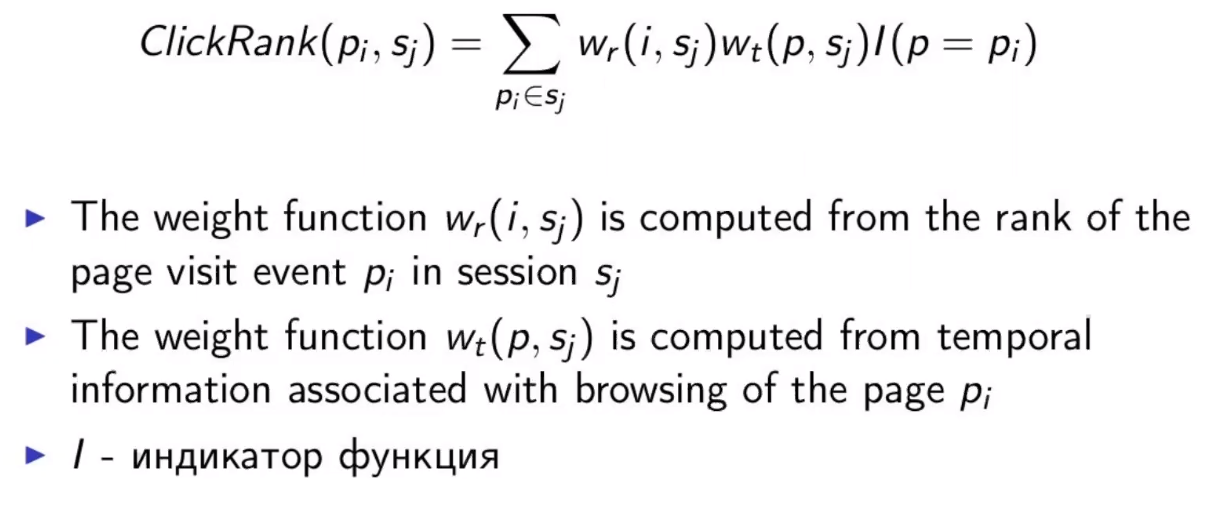

In [6]:
def click_rank(session, bunch_of_docs):
    # количество событий в сессии
    n_j = len(session)

    # r_i -- порядковый номер события
    for r_i, event in enumerate(session):
        # если это клик
        if event.type_of_action == "C":
            # по документу из подмножества интересующих
            if event.url_id in bunch_of_docs:
                # если он не последнее событие в сессии,
                if r_i + 1 < len(session):
                    # то считаем сколько времени пользователь провел на странице
                    t_d = session[r_i + 1].time_passed - event.time_passed
                # иначе
                else:
                    # он завершил на ней поисковую сессию,
                    # будем верить, что поисковик чьи логи имеются хороший и
                    # пользователи в итоге находят что искали, а не расстраиваются и уходят
                    # поэтому считаем что всё замечательно и пользователь провёл на странице максимально возможно время
                    t_d = np.inf
                # считаем соответственно коэффициенты для клик ранка
                # по позиции в сессии
                w_r_ = w_r(r_i, n_j)
                # и по времени проведенном на странице
                # время загрузки неизвестно, но пускай оно будет мгновенным, т.е. 1 -- игнорируем
                w_t_ = w_t(t_d)

                # прибавляем клик ранк
                docs[event.url_id].click_rank_sum += w_r_ * w_t_
                # и клик. В последствии можно будет по этим параметрам определить средний клик ранк страницы
                docs[event.url_id].clicked += 1


In [8]:
df = pd.read_csv("sample.csv")
unique_doc_ids = set(df["DocumentId"])


is_interested = False
last_session_id = 0
actions = []
bunch_of_docs = set()
with open(DATA_PATH + "/click_log", "r") as f:
    for line in tqdm(f, total=LINES):
        log = line[:-1].split("\t")

        current_session_id = int(log[0])
        # если пошла сессия не такая как была на прошлой итерации
        # то предыдущая сессия закончилась
        if current_session_id != last_session_id:
            # если в сессии встретился интересующий doc_id
            # (скипаем расчет метрик для сессий и документах в них если в них нет интересующих нас)
            if is_interested:
                # то считаем клик ранк интересующих страниц по этой сессии и остальную статистику
                click_rank(actions, bunch_of_docs)

                if_interested = False

            # обнуляем список действий и начинаем собирать по-новой
            actions = []
            bunch_of_docs = set()

        if log[2] == "Q":
            action = Query(log[0], log[1], log[2], log[3], log[4], log[4:])
            for doc_id in action.list_of_urls:
                if doc_id in unique_doc_ids:
                    is_interested = True
                    bunch_of_docs.add(doc_id)

        elif log[2] == "C":
            action = Click(log[0], log[1], log[2], log[3])
            # по идее пользователь не может кликнуть на то что не видит в выдаче
            # и этот документ уже помечен как интересующий в выдаче
            # но на всякий случай пусть и тут тоже пометится
            if action.url_id in unique_doc_ids:
                is_interested = True
                bunch_of_docs.add(doc_id)

        last_session_id = action.session_id
        actions.append(action)


100%|██████████| 340796067/340796067 [1:09:36<00:00, 81600.04it/s]


In [39]:
def ranking_function(metrics: Metrics) -> float:
    avg_click_rank = metrics.click_rank_sum / (metrics.clicked + 1e-10)

    return avg_click_rank

In [40]:
df = pd.read_csv("sample.csv")

for query_id in np.sort(df["QueryId"].unique()):
    serp = df[df["QueryId"] == query_id]["DocumentId"]
    scores = [(idx, ranking_function(docs[idx])) for idx in serp]
    ranked = sorted(scores, key=lambda x: x[1], reverse=True)
    ranked = [x[0] for x in ranked]
    ranked = np.array(ranked)
    df.loc[df["QueryId"] == query_id, "DocumentId"] = ranked

df.to_csv("submission.csv", index=False)


In [9]:
with open("docs.pkl", "bw") as f:
    pickle.dump(docs, f, protocol=pickle.HIGHEST_PROTOCOL)